<a href="https://colab.research.google.com/github/Adnane-Ahroum/BrainTumorPipeline/blob/main/classificationfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

This notebook has been modified to:
1. Add Weights & Biases (wandb) integration for experiment tracking
2. Properly load MATLAB data files from the repository

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import scipy.io as sio
import wandb

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim import Adam
from torchvision.models import densenet121

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import cv2
import PIL
from PIL import Image

## Data Loading - Fixed to work with repository files

In [3]:
def load_matlab_data(file_path):
    """Load data from a MATLAB .mat file.

    Args:
        file_path: Path to the .mat file.
    Returns:
        images: Numpy array of images
        labels: Numpy array of labels
    """
    # Make sure the file_path has .mat extension
    if not file_path.endswith('.mat'):
        file_path = file_path + '.mat'

    # Verify that the file exists
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"MATLAB file not found: {file_path}")

    mat_data = sio.loadmat(file_path)

    # Print available keys to debug
    print(f"Available keys in {file_path}: {list(mat_data.keys())}")

    # Common keys in MATLAB files - try different possibilities
    possible_image_keys = ['images', 'image', 'Images', 'Image', 'data', 'Data', 'X', 'features']
    possible_label_keys = ['labels', 'label', 'Labels', 'Label', 'y', 'classes', 'Categories']

    # Try to find image data
    images = None
    for key in possible_image_keys:
        if key in mat_data:
            images = mat_data[key]
            print(f"Found images under key: {key}")
            break

    # Try to find label data
    labels = None
    for key in possible_label_keys:
        if key in mat_data:
            labels = mat_data[key]
            print(f"Found labels under key: {key}")
            break

    if images is None or labels is None:
        raise ValueError("Could not find image or label data in the MATLAB file")

    # Handle potential dimensionality issues
    if labels.ndim > 1 and labels.shape[1] > 1:
        print("Warning: Labels have multiple columns, using first column")
        labels = labels[:, 0]

    return images, labels.ravel()  # Ensure labels are flattened

In [4]:
# Initialize wandb project
wandb.init(
    project="brain-tumor-classification",
    name="classification-experiment",
    config={
        "learning_rate": 0.001,
        "epochs": 30,
        "batch_size": 16,
        "model": "DenseNet121",
        "dataset": "Brain Tumor Dataset",
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adnaneahroum69 (adnaneahroum69-al-akhawayn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:

train_dir = '/content/drive/MyDrive/DATASETCLASSIFICATION/Training'
test_dir  = '/content/drive/MyDrive/DATASETCLASSIFICATION/Testing'


LOADING THE DATA FROM MATLAB FILES


In [7]:
!pip install mat73

In [8]:

import os
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split

# Optional: install mat73 (pip install mat73) for v7.3 files
import mat73

# Define tumor classes and labels
CLASSES = ['glioma', 'pituitary', 'meningioma']
CLASS_TO_LABEL = {cls: idx for idx, cls in enumerate(CLASSES)}

def load_mat_data(path, data_key='cjdata'):
    try:
        mat = sio.loadmat(path)
        print(f"Keys in MATLAB file: {mat.keys()}")
        if data_key in mat:
            return mat[data_key]
        raise KeyError(f"Key '{data_key}' not found in {path}")
    except NotImplementedError:
        mat = mat73.loadmat(path)
        print(f"Keys in MATLAB file (v7.3): {mat.keys()}")
        if data_key in mat:
            return mat[data_key]
        raise KeyError(f"Key '{data_key}' not found in {path} (v7.3)")


def load_data_for_three_tumors(root_dir, data_key='cjdata'):
    """Load images and labels for three tumor classes from subfolders."""
    images, labels = [], []
    for cls in CLASSES:
        subfolder = os.path.join(root_dir, cls)
        if not os.path.isdir(subfolder):
            raise FileNotFoundError(f"Missing folder: {subfolder}")
        for fname in os.listdir(subfolder):
            if not fname.endswith('.mat'): continue
            path = os.path.join(subfolder, fname)
            try:
                img = load_mat_data(path, data_key)
                images.append(img)
                labels.append(CLASS_TO_LABEL[cls])
            except Exception as e:
                print(f"Error loading {fname}: {e}")
    return np.array(images), np.array(labels)

# Usage in Colab after extracting dataset.zip
train_dir = '/content/drive/MyDrive/DATASETCLASSIFICATION/Training'
test_dir  = '/content/drive/MyDrive/DATASETCLASSIFICATION/Testing'

X_train, y_train = load_data_for_three_tumors(train_dir)
print(f"Training: {X_train.shape}, Labels: {y_train.shape}")

X_test, y_test = load_data_for_three_tumors(test_dir)
print(f"Testing:  {X_test.shape}, Labels: {y_test.shape}")

# Split train into train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)
print(f"After split → Train: {X_train.shape}, Val: {X_val.shape}")


Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])
Keys in MATLAB file (v7.3): dict_keys(['cjdata'])


In [26]:
# First, define your robust BrainTumorDataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

        # Debug info
        print(f"Dataset initialized with {len(images)} samples")
        print(f"Image type: {type(images)} with shape {images.shape if hasattr(images, 'shape') else 'unknown'}")
        if len(images) > 0:
            print(f"First image type: {type(images[0])}")
            if hasattr(images[0], 'shape'):
                print(f"First image shape: {images[0].shape}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # If image is a dictionary or a complex structure
        if isinstance(image, (dict, np.void)):
            # For numpy structured arrays
            if hasattr(image, 'dtype') and image.dtype.names:
                for field in ['image', 'data', 'img', 'Signal', 'pixels']:
                    if field in image.dtype.names:
                        image = image[field]
                        break
                else:
                    # Use first field that has array-like data
                    for field in image.dtype.names:
                        if hasattr(image[field], 'shape'):
                            image = image[field]
                            break
            # For dictionary structures
            elif isinstance(image, dict):
                for field in ['image', 'data', 'img', 'Signal', 'pixels']:
                    if field in image:
                        image = image[field]
                        break
                else:
                    # Use first value that has array-like data
                    for value in image.values():
                        if hasattr(value, 'shape'):
                            image = value
                            break

        # Convert to numpy array if it's not already
        if not isinstance(image, np.ndarray):
            try:
                image = np.array(image)
            except:
                # Create a blank image if conversion fails
                image = np.zeros((224, 224, 3), dtype=np.uint8)

        # Handle dimensionality
        if image.ndim == 2:  # Convert grayscale to RGB
            image = np.stack([image] * 3, axis=-1)
        elif image.ndim == 3 and image.shape[2] == 1:  # Handle single channel
            image = np.concatenate([image] * 3, axis=2)
        elif image.ndim > 3:  # Handle multi-dimensional data
            # Take the first 3D volume or middle slice
            if image.shape[0] > 0:
                image = image[image.shape[0]//2] if image.ndim == 4 else image[0]
                # If still 3D with depth, take middle slice
                if image.ndim == 3 and not (image.shape[2] == 3 or image.shape[2] == 1):
                    image = image[:, :, image.shape[2]//2]
                # Convert to RGB
                if image.ndim == 2:
                    image = np.stack([image] * 3, axis=-1)

        # Normalize and convert to uint8
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = np.clip(image, 0, 255).astype(np.uint8)

        # Make sure shape is correct for RGB
        if image.shape[2] != 3:
            # Handle unexpected channels
            if image.ndim == 3:
                if image.shape[2] > 3:
                    image = image[:, :, :3]  # Take first 3 channels
                else:
                    # Duplicate last channel
                    while image.shape[2] < 3:
                        image = np.concatenate([image, image[:, :, -1:]], axis=2)

        # Convert to PIL Image for transformations
        try:
            image = Image.fromarray(image)
        except Exception as e:
            print(f"Error converting to PIL: {e}")
            image = Image.new('RGB', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)

        return image, label

##MODEL DEFINITION


In [27]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = BrainTumorDataset(X_train, y_train, transform=train_transform)
val_dataset = BrainTumorDataset(X_val, y_val, transform=val_transform)

batch_size = wandb.config.batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Dataset initialized with 1961 samples
Image type: <class 'numpy.ndarray'> with shape (1961,)
First image type: <class 'dict'>
Dataset initialized with 491 samples
Image type: <class 'numpy.ndarray'> with shape (491,)
First image type: <class 'dict'>


Dataset initialized with 1961 samples
Image type: <class 'numpy.ndarray'> with shape (1961,)
First image type: <class 'dict'>
Dataset initialized with 491 samples
Image type: <class 'numpy.ndarray'> with shape (491,)
First image type: <class 'dict'>


## Training Function with wandb Integration

In [28]:
# Define the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained DenseNet121 model
model = densenet121(pretrained=True)
# Modify the last fully connected layer for 3 classes
num_classes = 3
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=wandb.config.learning_rate)
# Add more augmentations to train_transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Increased rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Add color jitter
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Add small translations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Implement a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# In your train_model function, add this after validation:
scheduler.step(val_acc)

Using device: cuda:0


In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training phase
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = running_loss / train_total
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

        # Log to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'confusion_matrix': wandb.Image(plt)
        })

        plt.close()

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_brain_tumor_classifier.pth')
            wandb.save('best_brain_tumor_classifier.pth')
            print(f"Saved best model with validation accuracy: {val_acc:.4f}")

    return model

##TRAIN THE MODEL

In [30]:
# Train the model
num_epochs = wandb.config.epochs
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/30: 100%|██████████| 123/123 [00:41<00:00,  2.95it/s]


Epoch 1/30
Train Loss: 0.6394, Train Acc: 0.7226
Val Loss: 4.8116, Val Acc: 0.4257
Saved best model with validation accuracy: 0.4257


Epoch 2/30: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s]


Epoch 2/30
Train Loss: 0.5022, Train Acc: 0.7940
Val Loss: 0.5125, Val Acc: 0.8167
Saved best model with validation accuracy: 0.8167


Epoch 3/30: 100%|██████████| 123/123 [00:40<00:00,  3.06it/s]


Epoch 3/30
Train Loss: 0.4362, Train Acc: 0.8123
Val Loss: 0.6674, Val Acc: 0.7352


Epoch 4/30: 100%|██████████| 123/123 [00:40<00:00,  3.06it/s]


Epoch 4/30
Train Loss: 0.4587, Train Acc: 0.8118
Val Loss: 0.5319, Val Acc: 0.7617


Epoch 5/30: 100%|██████████| 123/123 [00:40<00:00,  3.05it/s]


Epoch 5/30
Train Loss: 0.3959, Train Acc: 0.8399
Val Loss: 0.3924, Val Acc: 0.8473
Saved best model with validation accuracy: 0.8473


Epoch 6/30: 100%|██████████| 123/123 [00:40<00:00,  3.07it/s]


Epoch 6/30
Train Loss: 0.3876, Train Acc: 0.8358
Val Loss: 2.8495, Val Acc: 0.5682


Epoch 7/30: 100%|██████████| 123/123 [00:40<00:00,  3.05it/s]


Epoch 7/30
Train Loss: 0.3905, Train Acc: 0.8307
Val Loss: 0.5451, Val Acc: 0.8269


Epoch 8/30: 100%|██████████| 123/123 [00:40<00:00,  3.03it/s]


Epoch 8/30
Train Loss: 0.3654, Train Acc: 0.8389
Val Loss: 0.4812, Val Acc: 0.8065


Epoch 9/30: 100%|██████████| 123/123 [00:39<00:00,  3.09it/s]


Epoch 9/30
Train Loss: 0.3386, Train Acc: 0.8552
Val Loss: 0.7203, Val Acc: 0.7658


Epoch 10/30: 100%|██████████| 123/123 [00:40<00:00,  3.04it/s]


Epoch 10/30
Train Loss: 0.3114, Train Acc: 0.8638
Val Loss: 0.3529, Val Acc: 0.8534
Saved best model with validation accuracy: 0.8534


Epoch 11/30: 100%|██████████| 123/123 [00:40<00:00,  3.05it/s]


Epoch 11/30
Train Loss: 0.3401, Train Acc: 0.8572
Val Loss: 0.5911, Val Acc: 0.7495


Epoch 12/30: 100%|██████████| 123/123 [00:39<00:00,  3.11it/s]


Epoch 12/30
Train Loss: 0.3111, Train Acc: 0.8644
Val Loss: 0.7422, Val Acc: 0.8086


Epoch 13/30: 100%|██████████| 123/123 [00:40<00:00,  3.05it/s]


Epoch 13/30
Train Loss: 0.3383, Train Acc: 0.8582
Val Loss: 0.4671, Val Acc: 0.8086


Epoch 14/30: 100%|██████████| 123/123 [00:40<00:00,  3.07it/s]


Epoch 14/30
Train Loss: 0.2776, Train Acc: 0.8812
Val Loss: 0.3401, Val Acc: 0.8574
Saved best model with validation accuracy: 0.8574


Epoch 15/30: 100%|██████████| 123/123 [00:39<00:00,  3.09it/s]


Epoch 15/30
Train Loss: 0.2704, Train Acc: 0.8786
Val Loss: 0.3691, Val Acc: 0.8411


Epoch 16/30: 100%|██████████| 123/123 [00:39<00:00,  3.08it/s]


Epoch 16/30
Train Loss: 0.3420, Train Acc: 0.8511
Val Loss: 0.3430, Val Acc: 0.8269


Epoch 17/30: 100%|██████████| 123/123 [00:39<00:00,  3.08it/s]


Epoch 17/30
Train Loss: 0.2813, Train Acc: 0.8746
Val Loss: 0.7760, Val Acc: 0.7495


Epoch 18/30: 100%|██████████| 123/123 [00:40<00:00,  3.06it/s]


Epoch 18/30
Train Loss: 0.2696, Train Acc: 0.8858
Val Loss: 0.6905, Val Acc: 0.7373


Epoch 19/30: 100%|██████████| 123/123 [00:39<00:00,  3.13it/s]


Epoch 19/30
Train Loss: 0.2742, Train Acc: 0.8878
Val Loss: 0.3471, Val Acc: 0.8513


Epoch 20/30: 100%|██████████| 123/123 [00:39<00:00,  3.08it/s]


Epoch 20/30
Train Loss: 0.2571, Train Acc: 0.8914
Val Loss: 0.3559, Val Acc: 0.8656
Saved best model with validation accuracy: 0.8656


Epoch 21/30: 100%|██████████| 123/123 [00:39<00:00,  3.09it/s]


Epoch 21/30
Train Loss: 0.2562, Train Acc: 0.8970
Val Loss: 0.4700, Val Acc: 0.8269


Epoch 22/30: 100%|██████████| 123/123 [00:39<00:00,  3.11it/s]


Epoch 22/30
Train Loss: 0.2437, Train Acc: 0.9006
Val Loss: 0.6378, Val Acc: 0.7862


Epoch 23/30: 100%|██████████| 123/123 [00:39<00:00,  3.08it/s]


Epoch 23/30
Train Loss: 0.2427, Train Acc: 0.8980
Val Loss: 0.3524, Val Acc: 0.8982
Saved best model with validation accuracy: 0.8982


Epoch 24/30: 100%|██████████| 123/123 [00:40<00:00,  3.02it/s]


Epoch 24/30
Train Loss: 0.2380, Train Acc: 0.9046
Val Loss: 6.8785, Val Acc: 0.5336


Epoch 25/30: 100%|██████████| 123/123 [00:40<00:00,  3.04it/s]


Epoch 25/30
Train Loss: 0.2157, Train Acc: 0.9153
Val Loss: 0.3803, Val Acc: 0.8656


Epoch 26/30: 100%|██████████| 123/123 [00:40<00:00,  3.03it/s]


Epoch 26/30
Train Loss: 0.2274, Train Acc: 0.9072
Val Loss: 0.4451, Val Acc: 0.8493


Epoch 27/30: 100%|██████████| 123/123 [00:40<00:00,  3.04it/s]


Epoch 27/30
Train Loss: 0.2222, Train Acc: 0.9128
Val Loss: 1.3726, Val Acc: 0.6945


Epoch 28/30: 100%|██████████| 123/123 [00:40<00:00,  3.05it/s]


Epoch 28/30
Train Loss: 0.2149, Train Acc: 0.9189
Val Loss: 0.3663, Val Acc: 0.8758


Epoch 29/30: 100%|██████████| 123/123 [00:40<00:00,  3.06it/s]


Epoch 29/30
Train Loss: 0.2239, Train Acc: 0.9057
Val Loss: 0.5465, Val Acc: 0.8248


Epoch 30/30: 100%|██████████| 123/123 [00:40<00:00,  3.05it/s]


Epoch 30/30
Train Loss: 0.2010, Train Acc: 0.9184
Val Loss: 0.2708, Val Acc: 0.8737


## EVALUATE THEMODEL

Final Validation Accuracy: 0.8982

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       229
           1       0.95      0.94      0.94       156
           2       0.80      0.89      0.84       106

    accuracy                           0.90       491
   macro avg       0.89      0.90      0.89       491
weighted avg       0.90      0.90      0.90       491



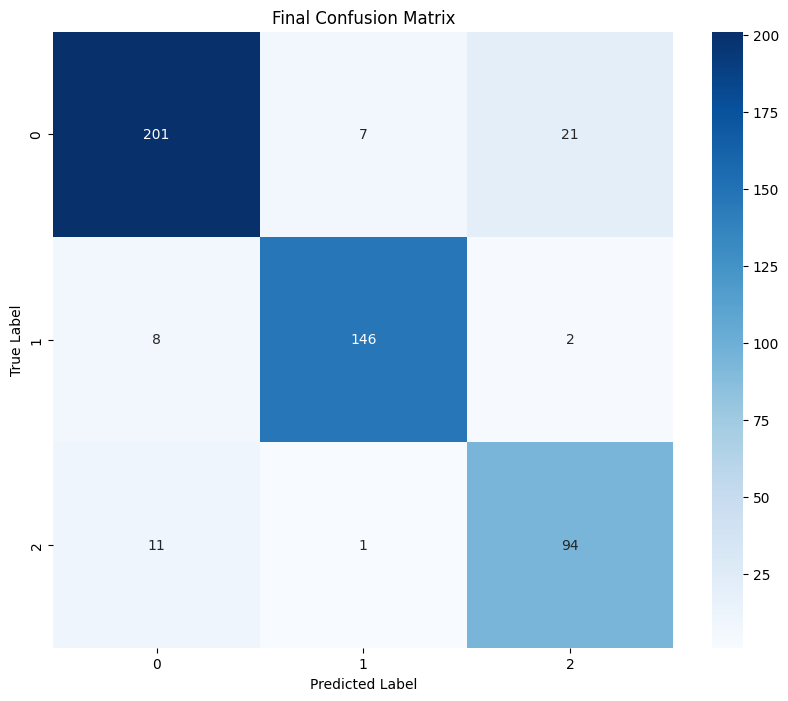

TypeError: 'numpy.ndarray' object is not callable

<Figure size 640x480 with 0 Axes>

In [31]:
# Load the best model
model.load_state_dict(torch.load('best_brain_tumor_classifier.pth'))
model.eval()

# Evaluate on validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and display metrics
accuracy = accuracy_score(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
conf_mat = confusion_matrix(all_labels, all_preds)

print(f"Final Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Final Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Log final metrics to wandb
wandb.log({
    'final_accuracy': accuracy,
    'final_confusion_matrix': wandb.Image(plt),
    'classification_report': wandb.Table(
        columns=["Class", "Precision", "Recall", "F1-Score", "Support"],
        data=[[i, *list(row.values())] for i, row in pd.DataFrame(classification_report(all_labels, all_preds, output_dict=True)).T.iterrows()]
    )
})

# Finish the wandb run
wandb.finish()